In [1]:
# 1) 한글 폰트 설치
!apt-get -y install fonts-nanum fonts-noto-cjk > /dev/null

# 2) 매트플롯립에 폰트 등록 및 기본 폰트 지정
import matplotlib as mpl
from matplotlib import font_manager as fm
import glob, os

# 설치된 나눔/노토 폰트 경로 자동 탐색 후 등록
font_paths = []
font_paths += glob.glob("/usr/share/fonts/truetype/nanum/*.ttf")
font_paths += glob.glob("/usr/share/fonts/opentype/noto/*CJK*.otf")
font_paths += glob.glob("/usr/share/fonts/opentype/noto/*CJK*.ttc")

for p in font_paths:
    try:
        fm.fontManager.addfont(p)
    except Exception:
        pass

# 3) 기본 폰트 패밀리 지정(우선순위)
mpl.rcParams["font.family"] = ["NanumGothic", "Noto Sans CJK KR", "AppleGothic", "Malgun Gothic", "DejaVu Sans"]
mpl.rcParams["axes.unicode_minus"] = False

# 4) 폰트 캐시 재로딩(중요)
try:
    fm._load_fontmanager(try_read_cache=False)  # Matplotlib >=3.6 권장
except Exception:
    fm._rebuild()  # 구버전 대응

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

DATE_COL_PATTERN = re.compile(r'^\s*\d{4}\.(?:0?[1-9]|1[0-2])\s*$')

def to_month_end_datetime(s):
    s = str(s).strip()
    s = re.sub(r'\s*p\)\s*$', '', s)   # ' p)' 제거
    dt = pd.to_datetime(s, format='%Y.%m', errors='coerce')
    if pd.isna(dt):
        return pd.NaT
    return pd.Period(dt, freq='M').to_timestamp(how='end')

def detect_date_columns(df):
    return [c for c in df.columns if DATE_COL_PATTERN.match(str(c))]

def melt_wide_monthly(df, id_col=None):
    date_cols = detect_date_columns(df)
    if not date_cols:
        return None
    id_vars = [id_col] if (id_col is not None and id_col in df.columns) else []
    long_df = df.melt(id_vars=id_vars, value_vars=date_cols,
                      var_name='DateStr', value_name='Value')
    long_df['Date'] = long_df['DateStr'].apply(to_month_end_datetime)
    long_df = long_df[['Date','Value']].dropna().sort_values('Date')
    return long_df

def load_series_auto(csv_path, preferred_label_col=None, preferred_label_value=None):
    last_err = None
    for enc in ['utf-8-sig','cp949','euc-kr','utf-8']:
        try:
            df = pd.read_csv(csv_path, encoding=enc)
            break
        except Exception as e:
            last_err = e
            df = None
    if df is None:
        raise RuntimeError(f"CSV 읽기 실패: {last_err}")

    if preferred_label_col and preferred_label_col in df.columns and preferred_label_value is not None:
        df = df[df[preferred_label_col].astype(str).str.strip() == str(preferred_label_value).strip()]

    long_df = melt_wide_monthly(df, id_col=preferred_label_col if (df is not None and preferred_label_col in df.columns) else None)
    if long_df is not None and not long_df.empty:
        s = pd.Series(long_df['Value'].astype(float).values, index=long_df['Date'].values)
        s = s[~s.index.duplicated(keep='last')].sort_index()
        return s

    date_candidates = [c for c in df.columns if str(c).strip() in ['Date','날짜','기간','기준월','월']]
    val_candidates  = [c for c in df.columns if str(c).strip() in ['Value','값','지수','지표값','Index','IndexValue','값(지수)']]
    if not val_candidates:
        numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        if len(numeric_cols) == 1:
            val_candidates = numeric_cols

    if date_candidates and val_candidates:
        dcol, vcol = date_candidates[0], val_candidates[0]
        tmp = df[[dcol, vcol]].copy()
        tmp['Date'] = tmp[dcol].apply(lambda x: to_month_end_datetime(x) if pd.notna(x) else pd.NaT)
        tmp = tmp[['Date', vcol]].dropna().rename(columns={vcol:'Value'})
        s = pd.Series(tmp['Value'].astype(float).values, index=tmp['Date'].values)
        s = s[~s.index.duplicated(keep='last')].sort_index()
        return s

    raise ValueError(f"형식 자동 인식 실패. 열 목록: {list(df.columns)}")

def bk_cycle(series_log, low=18, high=96, K=12):
    cyc = sm.tsa.filters.bkfilter(series_log.dropna(), low=low, high=96, K=K)
    cyc.name = 'cycle'
    return cyc

def zscore_over_overlap(s1, s2):
    common_idx = s1.index.intersection(s2.index)
    a = s1.loc[common_idx]
    b = s2.loc[common_idx]
    az = (a - a.mean()) / a.std(ddof=0)
    bz = (b - b.mean()) / b.std(ddof=0)
    return az, bz

def normalize_base100_over_overlap(level1, level2):
    common_idx = level1.index.intersection(level2.index)
    a = level1.loc[common_idx].astype(float)
    b = level2.loc[common_idx].astype(float)
    a_norm = a / a.iloc[0] * 100.0
    b_norm = b / b.iloc[0] * 100.0
    return a_norm, b_norm

In [3]:
from google.colab import files
uploaded = files.upload()
list(uploaded.keys())

Saving ip_index.csv to ip_index.csv
Saving shipment_inventory_index.csv to shipment_inventory_index.csv


['ip_index.csv', 'shipment_inventory_index.csv']

In [5]:
# === 셀 3: IP(BK) + log(출하/재고)(BK) 한 번에 준비 ===
IP_CSV = 'ip_index.csv'                     # 전산업생산지수(wide, '산업별 지수' 포함)
SR_CSV = 'shipment_inventory_index.csv'     # 생산자제품 출하/재고(계절조정) wide 테이블

import re, numpy as np, pandas as pd, statsmodels.api as sm

# 날짜 패턴 및 파서
DATE_RE = re.compile(r'^\s*\d{4}[./-](?:0?[1-9]|1[0-2])\s*$')
def to_month_end(s):
    s = str(s).strip()
    for fmt in ['%Y.%m','%Y-%m','%Y/%m']:
        try:
            dt = pd.to_datetime(s, format=fmt)
            return pd.Period(dt, freq='M').to_timestamp(how='end')
        except: pass
    return pd.NaT

def read_csv_any(path):
    for enc in ['utf-8-sig','cp949','euc-kr','utf-8']:
        try:
            return pd.read_csv(path, encoding=enc)
        except: pass
    raise RuntimeError(f"CSV 읽기 실패: {path}")

def span(s): return s.index.min().date(), s.index.max().date(), s.shape[0]

# -----------------------------
# 1) 전산업생산지수 → ip_cycle
# -----------------------------
ip_df = read_csv_any(IP_CSV)
# 전산업생산지수 행만
ip_df = ip_df[ip_df['산업별 지수'].astype(str).str.strip()=='전산업생산지수']
# 날짜 열 선별 → long → Series
ip_date_cols = [c for c in ip_df.columns if DATE_RE.match(str(c))]
assert len(ip_date_cols) >= 6, "ip_index.csv: 날짜형 열 부족"
long_ip = ip_df.melt(id_vars=['산업별 지수'], value_vars=ip_date_cols,
                     var_name='DateStr', value_name='Value')
long_ip['Date'] = long_ip['DateStr'].apply(to_month_end)
ip_level = pd.Series(pd.to_numeric(long_ip['Value'], errors='coerce').values,
                     index=long_ip['Date']).dropna()
ip_level = ip_level[~ip_level.index.duplicated(keep='last')].sort_index()
print("IP 레벨 범위:", span(ip_level))

# 로그 → BK(18~96, K=12)
ip_log   = np.log(ip_level.astype(float))
ip_cycle = sm.tsa.filters.bkfilter(ip_log.dropna(), low=18, high=96, K=12)
print("IP(BK) 범위:", span(ip_cycle.dropna()))

# -------------------------------------------
# 2) 출하/재고 로그비율 → sr_cycle (wide 헤더)
# -------------------------------------------
sr_df = read_csv_any(SR_CSV)
date_cols = [c for c in sr_df.columns if DATE_RE.match(str(c))]
assert len(date_cols) >= 6, "shipment_inventory_index.csv: 날짜형 열 부족"

# 총지수 & 계절조정인 행 선택 헬퍼
def pick_row(df, acct='총지수', keyword='출하'):
    m = (df['계정항목'].astype(str).str.strip()==acct) & \
        (df['구분코드'].astype(str).str.contains(keyword)) & \
        (df['구분코드'].astype(str).str.contains('계절조정'))
    row = df.loc[m]
    if row.empty:
        # 완화 매칭(상위 총괄)
        m2 = (df['구분코드'].astype(str).str.contains(keyword)) & \
             (df['구분코드'].astype(str).str.contains('계절조정'))
        row = df.loc[m2].head(1)
    return row

row_ship = pick_row(sr_df, acct='총지수', keyword='출하')
row_inv  = pick_row(sr_df, acct='총지수', keyword='재고')
assert not row_ship.empty, "출하지수(계절조정) 행을 찾지 못함"
assert not row_inv.empty,  "재고지수(계절조정) 행을 찾지 못함"

def row_to_series(row):
    long = row.melt(value_vars=date_cols, var_name='DateStr', value_name='Value')
    long['Date'] = long['DateStr'].apply(to_month_end)
    s = pd.Series(pd.to_numeric(long['Value'], errors='coerce').values, index=long['Date']).dropna()
    return s[~s.index.duplicated(keep='last')].sort_index()

ship = row_to_series(row_ship)
inv  = row_to_series(row_inv)
print("출하지수 범위:", span(ship))
print("재고지수 범위:", span(inv))

# log(출하/재고) 계산
common_si = ship.index.intersection(inv.index)
spread_log = np.log(ship.loc[common_si].astype(float)) - np.log(inv.loc[common_si].astype(float))
spread_log.name = 'log(Shipment/Inventory)'
print("log(출하/재고) 범위:", span(spread_log.dropna()))

# BK(18~96, K=12)
sr_cycle = sm.tsa.filters.bkfilter(spread_log.dropna(), low=18, high=96, K=12)
print("log(출하/재고)(BK) 범위:", span(sr_cycle.dropna()))

# 공통 구간 안내 (IP vs SR)
idx_common = ip_cycle.dropna().index.intersection(sr_cycle.dropna().index)
print("공통 구간(IP vs log(출하/재고) BK):", idx_common.min().date(), "→", idx_common.max().date(), f"({len(idx_common)}개월)")

# 이 셀 실행 후: 기존 셀 4SR(그래프/상관·시차/R²·RMSE) 바로 실행

IP 레벨 범위: (datetime.date(2000, 1, 31), datetime.date(2025, 4, 30), 304)
IP(BK) 범위: (datetime.date(2001, 1, 31), datetime.date(2024, 4, 30), 280)
출하지수 범위: (datetime.date(2000, 1, 31), datetime.date(2025, 6, 30), 306)
재고지수 범위: (datetime.date(2000, 1, 31), datetime.date(2025, 6, 30), 306)
log(출하/재고) 범위: (datetime.date(2000, 1, 31), datetime.date(2025, 6, 30), 306)
log(출하/재고)(BK) 범위: (datetime.date(2001, 1, 31), datetime.date(2024, 6, 30), 282)
공통 구간(IP vs log(출하/재고) BK): 2001-01-31 → 2024-04-30 (280개월)


상관(z): 0.605
최고 교차상관: lag=2개월, corr=0.719
해석: 출하/재고 로그비율이 선행
[IP ← log(출하/재고)]  R²: 0.367 RMSE: 0.007


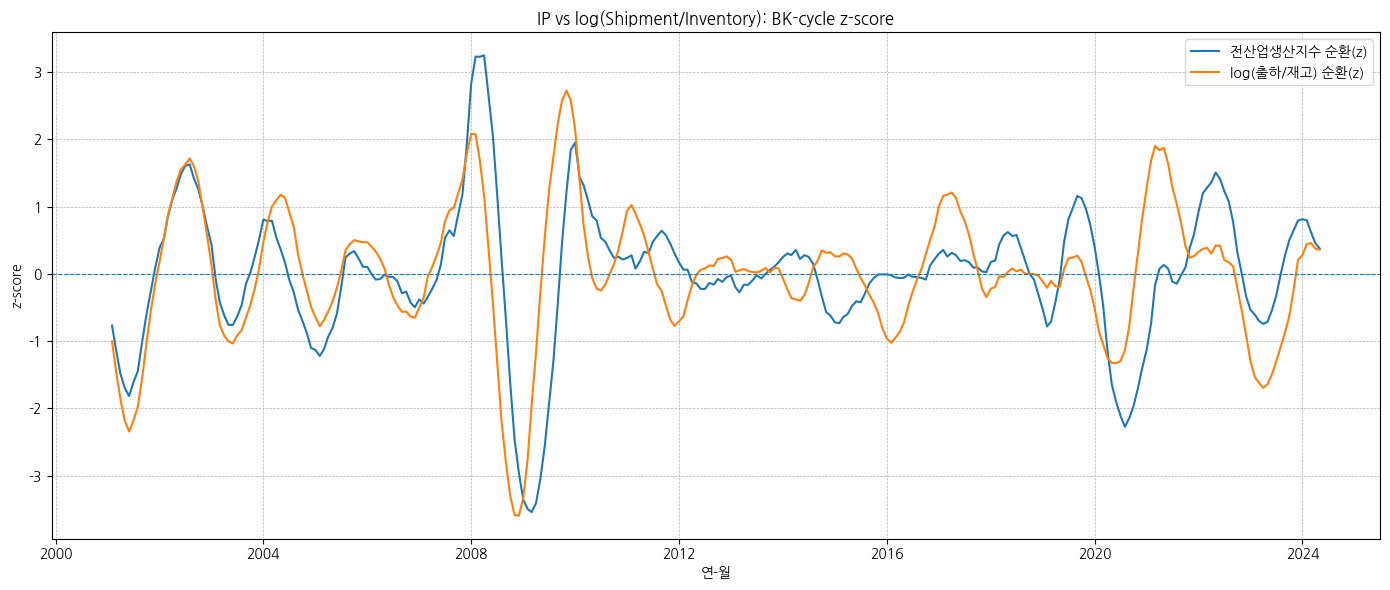

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import numpy as np

# 공통 구간
idx = ip_cycle.dropna().index.intersection(sr_cycle.dropna().index)
ip_c = ip_cycle.loc[idx]
sr_c = sr_cycle.loc[idx]

# z-score
ip_z = (ip_c - ip_c.mean()) / ip_c.std(ddof=0)
sr_z = (sr_c - sr_c.mean()) / sr_c.std(ddof=0)

# 상관 및 시차
r = ip_z.corr(sr_z)
print("상관(z):", round(float(r), 3))

def best_lag(a, b, max_lag=12):
    best = (0, a.corr(b))
    for lag in range(-max_lag, max_lag+1):
        if lag==0: continue
        corr = a.corr(b.shift(lag))
        if pd.notna(corr) and corr > best[1]:
            best = (lag, corr)
    return best

lag, lag_corr = best_lag(ip_z, sr_z, max_lag=12)
print(f"최고 교차상관: lag={lag}개월, corr={round(float(lag_corr),3)}")
print("해석:",
      "출하/재고 로그비율이 선행" if lag>0 else
      "전산업생산이 선행"        if lag<0 else
      "뚜렷한 선행·후행 없음")

# 회귀: IP ← 출하/재고 로그비율 (설명력 기준)
y = ip_c.values
X = sm.add_constant(sr_c.values)
m = sm.OLS(y, X).fit()
pred = m.predict(X)
print("[IP ← log(출하/재고)]  R²:", round(m.rsquared, 3),
      "RMSE:", round(float(np.sqrt(mean_squared_error(y, pred))), 3))
# print(m.summary())  # 상세표 필요 시

# 그래프
plt.figure(figsize=(14,6))
plt.plot(ip_z.index, ip_z.values, label='전산업생산지수 순환(z)')
plt.plot(sr_z.index, sr_z.values, label='log(출하/재고) 순환(z)')
plt.axhline(0, linestyle='--', linewidth=0.8)
plt.title('IP vs log(Shipment/Inventory): BK-cycle z-score')
plt.xlabel('연-월'); plt.ylabel('z-score')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(); plt.tight_layout(); plt.show()